## Import Required Libraries

In [49]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

## Loading the model and preparing

In [50]:
def load_model(model_dir):
    # Load preset model to color gray images or videos
    prototxt_path = os.path.join(model_dir, "colorization_deploy_v2.prototxt")
    model_path = os.path.join(model_dir, "colorization_release_v2.caffemodel")
    points_path = os.path.join(model_dir, "pts_in_hull.npy")

    model = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

    # Load clustered points to reconstruct color channels
    cluster_points = np.load(points_path)
    cluster_points = cluster_points.transpose().reshape(2, 313, 1, 1)

    # Setting the parameters of specific layers in the network
    class8_id = model.getLayerId("class8_ab")
    conv8_id = model.getLayerId("conv8_313_rh")
    model.getLayer(class8_id).blobs = [cluster_points.astype("float32")]
    model.getLayer(conv8_id).blobs = [np.full([1, 313], 2.606, dtype="float32")]

    return model

model_directory = "models" 
print("Loading model...")
colorization_model = load_model(model_directory)

Loading model...


## Image preprocessing

In [51]:
def preprocess_image(image_path):
    # Image preprocessing to prepare model input
    image = cv2.imread(image_path)
    
    # Scaling the value of pixels to the interval [0, 1]
    scaled_image = image.astype("float32") / 255.0
    
    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(scaled_image, cv2.COLOR_BGR2LAB)

    resized_lab = cv2.resize(lab_image, (224, 224))
    
    # L channel extraction and its normalization
    l_channel = cv2.split(resized_lab)[0]
    l_channel -= 50

    return image, lab_image, l_channel

input_image_path = "blackpic.jpg" 
print("Preprocessing image...")
original_img, lab_img, l_channel_input = preprocess_image(input_image_path)

Preprocessing image...


## Colorize the image

In [52]:
def colorize_image(model, lab_image, l_channel):
    # Colorizing a black and white image using a prediction model
    
    # Predict ab channels with the model
    model.setInput(cv2.dnn.blobFromImage(l_channel))
    predicted_ab = model.forward()[0, :, :, :].transpose((1, 2, 0))

    predicted_ab_resized = cv2.resize(predicted_ab, (lab_image.shape[1], lab_image.shape[0]))

    l_channel_original = cv2.split(lab_image)[0]
    colorized_lab = np.concatenate((l_channel_original[:, :, np.newaxis], predicted_ab_resized), axis=2)

    colorized_bgr = cv2.cvtColor(colorized_lab, cv2.COLOR_LAB2BGR)
    # Limit the values to [0, 1] and then to [0, 255]
    colorized_bgr = np.clip(colorized_bgr, 0, 1) 
    colorized_bgr = (colorized_bgr * 255).astype("uint8") 

    return colorized_bgr

print("Colorizing image...")
colorized_img = colorize_image(colorization_model, lab_img, l_channel_input)

Colorizing image...


## Save and display results

Saving and displaying results...


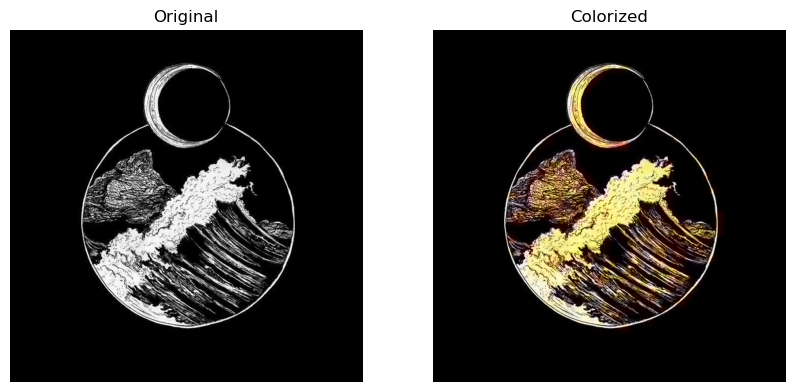

In [53]:
def save_and_display_results(original_image, colorized_image, output_path):
    # Save and display the original image and the colored image
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, colorized_image)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Colorized")
    plt.imshow(cv2.cvtColor(colorized_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()

output_image_path = "output/colorized_image.jpg" 
print("Saving and displaying results...")
save_and_display_results(original_img, colorized_img, output_image_path)

## Import Required Libraries

In [54]:
import numpy as np
import cv2
import os

## Model file paths

In [55]:
# Model file paths
DIR = os.path.join(os.getcwd())
PROTOTXT = os.path.join(DIR, "models", "colorization_deploy_v2.prototxt")
POINTS = os.path.join(DIR, "models", "pts_in_hull.npy")
MODEL = os.path.join(DIR, "models", "colorization_release_v2.caffemodel")

# Input video path
VIDEO_NAME = "video"
VIDEO_PATH = os.path.join(DIR, "videos", f"{VIDEO_NAME}.mp4")

OUTPUT_PATH = os.path.join(DIR, "videosOutput", f"{VIDEO_NAME}.mp4")
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

print("Paths initialized.")

Paths initialized.


## Loading the model and preparing 

In [56]:
def load_model(prototxt, model, points):
    # Loading the model and preparing for color restoration
    net = cv2.dnn.readNetFromCaffe(prototxt, model)
    pts = np.load(points)
    pts = pts.transpose().reshape(2, 313, 1, 1)

    class8 = net.getLayerId("class8_ab")
    conv8 = net.getLayerId("conv8_313_rh")
    net.getLayer(class8).blobs = [pts.astype("float32")]
    net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

    return net

print("Loading model...")
colorization_model = load_model(PROTOTXT, MODEL, POINTS)

Loading model...


## Video preparation

In [57]:
def initialize_video(video_path, output_path):
    # Open the input video and prepare to save the output video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError("Error: Could not open video.")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    return cap, out

print("Initializing video...")
cap, out = initialize_video(VIDEO_PATH, OUTPUT_PATH)

Initializing video...


## Video processing and frame coloring

In [58]:
def process_and_colorize_video(cap, out, model):
    # Colorize the video frame by frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Frame preprocessing
        scaled = frame.astype("float32") / 255.0
        lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

        resized = cv2.resize(lab, (224, 224))
        L = cv2.split(resized)[0]
        L -= 50
        
        # Frame color prediction
        model.setInput(cv2.dnn.blobFromImage(L))
        ab = model.forward()[0, :, :, :].transpose((1, 2, 0))

        ab = cv2.resize(ab, (frame.shape[1], frame.shape[0]))
        L = cv2.split(lab)[0]
        colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

        colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
        colorized = np.clip(colorized, 0, 1)
        colorized = (255 * colorized).astype("uint8")
        
        # Save the colored frame
        out.write(colorized)

print("Processing video...")
process_and_colorize_video(cap, out, colorization_model)

Processing video...


## Release of resources

In [59]:
def release_resources(cap, out):
    # Release video resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()

print("Releasing resources...")
release_resources(cap, out)

print(f"Colorized video saved to {OUTPUT_PATH}")

Releasing resources...
Colorized video saved to /Users/m2/Documents/code/python/Basics of computer vision/project/Convert photos and videos to color/videosOutput/video.mp4



### 1. مقدمه
در این پروژه هدف اصلی تبدیل تصاویر و ویدئوهای سیاه و سفید به رنگی با استفاده از الگوریتم‌های هوش مصنوعی و یادگیری عمیق است. این فرایند از شبکه‌های عصبی کانولوشنی (CNN) بهره می‌برد که به طور خاص برای پیش‌بینی رنگ‌های تصاویر سیاه و سفید طراحی شده‌اند. پروژه با استفاده از مدل‌های پیش‌آماده که بر اساس Caffe ساخته شده‌اند، پیاده‌سازی شده است.

هدف این پروژه نه تنها بهبود کیفیت رنگ‌آمیزی تصاویر است، بلکه کاربرد آن را در ویدئوها نیز گسترش می‌دهد. به این ترتیب، این پروژه به طور خودکار می‌تواند رنگ‌های تصاویر و ویدئوهای سیاه و سفید را بازسازی کند و به کیفیت بالاتری نسبت به روش‌های سنتی تبدیل آنها به رنگی دست یابد.

### 2. تحقیق و پیشینه
تحقیقات و تکنیک‌های مختلفی برای رنگی کردن تصاویر و ویدئوها با استفاده از مدل‌های یادگیری عمیق انجام شده‌اند. در این پروژه از یک مدل پیش‌آماده مبتنی بر Caffe استفاده شده است که به طور خاص برای رنگی کردن تصاویر سیاه و سفید طراحی شده است. این مدل توسط Rich Zhang و تیمش توسعه داده شده و در گیت‌هاب و منابع مختلف قابل دسترسی است.

**مدل‌های استفاده شده:**
- [colorization_release_v2.caffemodel](https://www.dropbox.com/s/dx0qvhhp5hbcx7z/colorization_release_v2.caffemodel?dl=1) که شامل وزن‌های مدل برای پیش‌بینی رنگ‌ها است.
- [pts_in_hull.npy](https://github.com/richzhang/colorization/blob/caffe/colorization/resources/pts_in_hull.npy) که شامل نقاط خوشه‌بندی برای مدل است.
- [colorization_deploy_v2.prototxt](https://github.com/richzhang/colorization/blob/caffe/colorization/models/colorization_deploy_v2.prototxt) که ساختار معماری مدل را تعریف می‌کند.

این مدل‌ها با استفاده از شبکه‌های عصبی کانولوشنی (CNN) آموزش دیده‌اند که وظیفه آنها پیش‌بینی رنگ‌های مطلوب برای تصاویر سیاه و سفید است.

### 3. اهداف پروژه
اهداف این پروژه به شرح زیر است:
- **تبدیل تصاویر سیاه و سفید به رنگی**: استفاده از مدل‌های یادگیری عمیق برای رنگی کردن تصاویر.
- **تبدیل ویدئوها به رنگی**: پردازش ویدئوها به‌طور فریم‌به‌فریم و رنگی کردن هر فریم به‌طور مجزا.
- **ارزیابی عملکرد مدل‌ها**: بررسی کیفیت نتایج از لحاظ دقت رنگی، زمان پردازش و عملکرد کلی.

این پروژه نه تنها یک چالش در زمینه تبدیل تصاویر است، بلکه گام مهمی در بهبود روش‌های پردازش ویدئوهای سیاه و سفید به شمار می‌رود.

### 4. روش کار
در این پروژه از یک مدل پیش‌آماده Caffe استفاده شده است. مراحل پیاده‌سازی به صورت زیر است:

1. **بارگذاری مدل**: ابتدا مدل با استفاده از مسیرهای مشخص شده بارگذاری می‌شود. این مدل شامل سه فایل است:
   - `colorization_deploy_v2.prototxt` که ساختار مدل را مشخص می‌کند.
   - `colorization_release_v2.caffemodel` که وزن‌های مدل را شامل می‌شود.
   - `pts_in_hull.npy` که شامل نقاط خوشه‌بندی است.

2. **پیش‌پردازش تصاویر**: تصاویر وارد شده ابتدا به فرمت LAB تبدیل می‌شوند. این کار به منظور جدا کردن کانال L (که نمایانگر روشنایی است) انجام می‌شود. این مرحله برای پردازش دقیق‌تر رنگ‌ها و پیش‌بینی‌های مدل ضروری است.

3. **رنگی کردن تصاویر**: پس از پیش‌پردازش، مدل برای پیش‌بینی رنگ‌ها وارد عمل می‌شود. پیش‌بینی‌ها (AB) از مدل گرفته شده و سپس به کانال L اضافه می‌شود تا تصویر نهایی رنگی بازسازی گردد.

4. **پردازش ویدئوها**: برای ویدئوها، هر فریم به صورت جداگانه پردازش می‌شود. پس از رنگی کردن هر فریم، فریم‌ها دوباره به هم متصل شده و ویدئوی رنگی نهایی ساخته می‌شود.

5. **بهینه‌سازی و ارزیابی**: برای افزایش دقت و کاهش زمان پردازش، مدل و مراحل پردازش بهینه شده‌اند.

### 5. نتایج
نتایج پروژه شامل تبدیل تصاویر و ویدئوها از سیاه و سفید به رنگی است. در ادامه می‌توانید نتایج بدست‌آمده را بررسی کنید:

- **تصاویر**: تصاویر سیاه و سفید قبل و بعد از تبدیل به رنگی، که کیفیت رنگی شدن آنها با دقت ارزیابی می‌شود.
- **ویدئوها**: در این پروژه، ویدئوهایی که فریم به فریم پردازش شده‌اند و تبدیل به رنگی شده‌اند نیز نشان داده می‌شود.
- **عملکرد مدل**: ارزیابی دقت پیش‌بینی رنگ‌ها، زمان پردازش هر فریم یا تصویر و کارایی کلی مدل.

### 6. چالش‌ها و مشکلات
چالش‌های اصلی در پروژه عبارتند از:
- **مشکلات دقت رنگ‌ها**: در برخی از تصاویر، پیش‌بینی رنگ‌ها ممکن است دقیق نباشد، به‌ویژه در تصاویر با نورپردازی پیچیده یا کنتراست پایین.
- **زمان پردازش**: پردازش ویدئوها ممکن است زمان‌بر باشد، به ویژه اگر سیستم مورد استفاده دارای منابع محدود باشد.
- **کیفیت تصاویر ورودی**: در برخی موارد، تصاویر با کیفیت پایین ممکن است باعث کاهش دقت مدل در پیش‌بینی رنگ‌ها شوند.

### 7. نتیجه‌گیری
این پروژه با موفقیت توانست تصاویر و ویدئوهای سیاه و سفید را به رنگی تبدیل کند. استفاده از مدل‌های پیش‌آماده Caffe در این پروژه امکان دسترسی به نتایج با کیفیت بالا را فراهم کرده است. با این حال، برای بهبود بیشتر، نیاز به توسعه مدل‌های جدیدتر و بهینه‌سازی‌های بیشتر در سرعت پردازش وجود دارد.

پیشنهادات برای بهبود:
- **افزایش دقت مدل**: استفاده از مدل‌های پیچیده‌تر مانند GAN برای بهبود دقت پیش‌بینی رنگ‌ها.
- **کاهش زمان پردازش**: بهینه‌سازی کد برای استفاده از منابع سخت‌افزاری بهینه‌تر.

### 8. منابع
1. **مدل‌ها و فایل‌های مرتبط**:
   - [colorization_release_v2.caffemodel](https://www.dropbox.com/s/dx0qvhhp5hbcx7z/colorization_release_v2.caffemodel?dl=1)
   - [pts_in_hull.npy](https://github.com/richzhang/colorization/blob/caffe/colorization/resources/pts_in_hull.npy)
   - [colorization_deploy_v2.prototxt](https://github.com/richzhang/colorization/blob/caffe/colorization/models/colorization_deploy_v2.prototxt)
   
2. **مقالات و منابع آموزشی**:
   - Zhang, R., Isola, P., & Efros, A. A. (2016). Colorful Image Colorization. *arXiv preprint arXiv:1603.08511*.
   - https://github.com/richzhang/colorization